## Datascience project - Extraction and analysis of a twitter tweet DB

## Project explanation
The database used in this project is below:
https://dataverse.harvard.edu/dataverse/gwu-libraries
The GWU databases contains a list of tweets that will be hydrated later on. They contain specific subjects such as the 2016 american election, olympic games, and more events.

The goal of this project is to: 
1. Construct a *crawler* to collect tweet information using its ID
2. Using the collected tweets, apply ML/NLP algorithms to analyse the data.

# Tweets hydrations using twitter's API

# API keys

In [1]:
CONSUMER_KEY = "uHl7XoH0B1fKg7EZrVz46N3r7"
CONSUMER_SECRET = "HI5O8uHvZe7vz1pxluqRK5ZGj4rj4BYITsxT2uRa2ZBYkuI1qH"

oauth_token = "1747172539-IKARgUrFw8W9LlxrDaoZQpoLG44KDKZVM2v5DRX"
oauth_secret = "XzDjNnGgNg3cZ3QIADZqjykQGS1BZLYpKmT78oI8j17Hu"

In [2]:
import csv
import time
import sys
from twython import Twython, TwythonError, TwythonRateLimitError

# Application creation

In [3]:
twitter = Twython(CONSUMER_KEY, CONSUMER_SECRET, oauth_token, oauth_secret)

# Testing that the API works as intended

In [4]:
test_id = "1157345692517634049"
tweet = twitter.show_status(id=test_id)
tweet_date = tweet['created_at']
tweet_user = tweet['user']['name']
tweet_content = tweet['text']
print(tweet_date)
print(tweet_user)
print(tweet_content)

Fri Aug 02 17:41:30 +0000 2019
Donald J. Trump
A$AP Rocky released from prison and on his way home to the United States from Sweden. It was a Rocky Week, get home ASAP A$AP!


### 3. Tweets DB Hydration

Due to the twitter query limitation, the `show_status` from the twython library function will be ineffective for this task: at the rate of 900 queries for 15 minutes, it would take far too long to build a database. This being said, tweets hydration will be our solution and is necessary.

The `lookup_status` function will therefore be more suitable. We want to hydrate 100 tweets per request, which, due to a limit of 900 requests for 15 minutes, makes building the database more realistic.

In [5]:
def write_csv(tweet_list, features, writer):
    tweets_dicts = []
    for tweet in tweet_list:
        temp_dict = {}
        for feature_list in features:
            if len(feature_list) > 1:
                temp_dict[feature_list[1]] = tweet[feature_list[0]][feature_list[1]]
            else:
                temp_dict[feature_list[0]] = tweet[feature_list[0]] 
        tweets_dicts.append(temp_dict)

    for tweet_dictionary in tweets_dicts:
        writer.writerow(tweet_dictionary)
        
def hydrate_database(filename, database_name, 
                     features, nb_requests, 
                     tweet_hydratation_limit=100):
    
    # Creation of the file that will contain the hydrated tweets:
    with open(database_name, 'w', newline='', encoding="utf-8") as csvfile:
            tweet_test = None
            # Opening the ID File:
            id_list = []
            file = open(filename, "r")
            for line in file:
                id_list.append(line.rstrip("\n"))
               
            fieldnames = []
            # constructing the features list                
            for feature_list in features:
                if len(feature_list) > 1:
                    fieldnames.append(feature_list[1])
                else:
                    fieldnames.append(feature_list[0])
            writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
            writer.writeheader()
            for i in range(nb_requests + 1):     
                try: # If you don't reach the limit of requests
                    tweet_test = twitter.lookup_status(id = id_list[i*tweet_hydratation_limit:(i*tweet_hydratation_limit)+tweet_hydratation_limit])
                    write_csv(tweet_test, features, writer)
                except TwythonError as e:
                    if isinstance(e, TwythonRateLimitError):
                        retry_after = int(e.retry_after)
                        #Get the difference between the current time and the time where it should retry 
                        wait_time = retry_after - time.time()
                        print(wait_time)
                        time.sleep(wait_time + 2)
                        tweet_test = twitter.lookup_status(id = id_list[i*tweet_hydratation_limit:(i*tweet_hydratation_limit)+tweet_hydratation_limit])
                        write_csv(tweet_test, features, writer)
                except Exception as e:
                    print('An error has occured :' + e)
               
    file.close()

In [ ]:
filename = "gwu/climate_id.txt"
database_name = "databases/climate.csv"
features = [['text'], ['user', 'screen_name']]
nb_requests = 400

hydrate_database(filename, database_name, features, nb_requests, tweet_hydratation_limit=100)

# Clustering methods applied to the tweet on news, and analysis of the results.
    
Dataset: ** "News Outlet Tweet Ids", https://doi.org/10.7910/DVN/2FIFLH

Application of preprocessing methods, then clustering methods to group tweets that mention the same news or news category , Then visualization of our results. 


### Dataset presentation

In [6]:
#Hydratation
filename = "gwu/news_outlets.txt"
database_name = "databases/real_data_exctraction.csv"

#### Hydrating and extracting tweets

In [ ]:
features = [['text'], ['user', 'location'], ['user', 'screen_name'],['user', 'name'], ['created_at'], ['lang'], ['retweet_count'], ['favorite_count'], ['user','description']]
nb_requests = 5000

hydrate_database(filename, database_name, features, nb_requests, tweet_hydratation_limit=100)

### Reading the extracted hydrated tweets

In [7]:
import pandas as pd

In [8]:
colnames = ['text', 'location','screen_name', 'name','created_at', 'lang', 'retweet_count', 'favorite_count', 'description' ]
data = pd.read_csv(database_name, names=colnames)
text = data.text.tolist()
location = data.location.tolist()
screen_name = data.screen_name.tolist()
name = data.name.tolist()
created_at = data.created_at.tolist()
languages = data.lang.tolist()
retweet_count = data.retweet_count.tolist()
favorite_count = data.favorite_count.tolist()
description = data.description.tolist()
all_attributes = [text, location, created_at, languages, description, favorite_count, retweet_count, name, screen_name]

C:\Users\Elio\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3058: DtypeWarning: Columns (6,7) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [9]:
print("----------------TEXTS----------------")
print(text[:10])
print("----------------LOCATIONS----------------")
print(location[:10])
print("----------------CREATED_AT----------------")
print(created_at[:10])
print("----------------LANGUAGES----------------")
print(languages[:10])



----------------TEXTS----------------
['text', "Timeline of Fidel Castro's life https://t.co/HgN0iyQz0L https://t.co/c59GxrRaMx", 'Polls open in Kuwait as opposition returns https://t.co/IBfZPJ9Ilt https://t.co/1rUoNmdPcq', "In Havana, music stops as Cubans mourn 'father' Castro https://t.co/rKzhGyabn6 https://t.co/USkbiCbAXL", 'Foldable Cardboard Tube Brings Easy Eye Test to Developing World https://t.co/XqjGpyjoVk https://t.co/o1N0o4I90g', 'Disidentes en Miami celebran muerte de Fidel Castro https://t.co/ELo5Wqx0jY https://t.co/1Z2X5K2tS7', 'Marianne Faithfull pays homage to Paris victims at Bataclan https://t.co/kchA0HcuiA https://t.co/00OpeneevO', "Putin praises Castro as 'symbol of an era': Kremlin https://t.co/1znPoCkYBi https://t.co/FcgKy1nzYR", 'Pope to Everyman: Reaction to the Death of former Cuban President Fidel Castro https://t.co/EvSi0c9qKy https://t.co/BtuQ8PEsCM', 'Iran arrests three over deadly train crash https://t.co/b8Q2n3NBEh https://t.co/ESnUgszf7T']
-------------


### Preprocessing


In [10]:
import sys
import nltk

##### Removing non english tweets

In [11]:
indexes_to_keep = []

class TweetsFilter(object):
    def remove_non_english(self, all_attributes):
        all_eng_attributes = []
        for i, value in enumerate(all_attributes[3]):
            if value == "en":
                indexes_to_keep.append(i)
        for attribute_list in all_attributes:
            new_list = [] 
            for index in indexes_to_keep:
                new_list.append(attribute_list[index])
            all_eng_attributes.append(new_list)
            
        return all_eng_attributes

In [12]:
tweet_filter = TweetsFilter()
all_eng_attributes = tweet_filter.remove_non_english(all_attributes)
text = all_eng_attributes[0]
location = all_eng_attributes[1]
created_at = all_eng_attributes[2]
languages = all_eng_attributes[3]

#### Tweet emoji removal

In [14]:
import emoji
class EmojisRemover(object):
    
    def remove_emojis(self, text):
        allchars = [str for str in text]
        emoji_list = [c for c in allchars if c in emoji.UNICODE_EMOJI]
        clean_text = ' '.join([str for str in text.split() if not any(i in str for i in emoji_list)])
        return clean_text

##### Tweet tokenization using TweetTokenizer

In [15]:
from nltk.tokenize import TweetTokenizer

class NLTKTokenizer(object):
    
    def tokenize(self, text):
        text = text.lower()
        tweetTokenizer = TweetTokenizer(preserve_case=False,
                               reduce_len=True,
                               strip_handles=False)
        splitTweet = tweetTokenizer.tokenize(text)
        pre_words = []
        for word in splitTweet:
            # Mot alphabetique, stop words et longueur de 1
            if word.isalpha() and len(word) > 1:
                pre_words.append(word)

        # Have to return a list of tokens
        return pre_words


##### Remove Stopwords

In [16]:
from nltk.corpus import stopwords
class StopwordsRemover(object):
    def remove_stopwords(self, tweet):
        stopwords_list = set(stopwords.words("english"))
        return [token for token in tweet if token not in stopwords_list]
       

##### Stemming 

In [17]:
from nltk.stem.snowball import SnowballStemmer

class Stemmer(object):

    def __init__(self):
        self.stemmer = SnowballStemmer("english")

    def stem(self, tokens):
        """
        tokens: a list of strings
        """
        stems = map(self.stemmer.stem, tokens)
        # Have to return a list of stems
        return list(stems)

##### Punctuations, http links and "RT" word removal

In [18]:
import string
import re

class UselessInfoRemover(object):
    def remove_useless_info(self, tweet):
        punctuations = ['.', ',', '?', '!', "'", '"', ';', ':', '...', '-', '_', '(', ')', '[', ']']
        new_tweet = []
        for word in tweet:
            if word not in punctuations and not re.search(r'\d', word) and word.find('http') == -1 and word.find('https') == -1 and word.find('rt') == -1:
                new_tweet.append(word)
        # return the preprocessed twitter
        return new_tweet

#### Preprocessing pipeline

In [19]:
class PreprocessingPipeline:

    def __init__(self, emoji_remover, tokenization, stopwords_remover, useless_info_remover, stemming):

        self.emoji_remover = EmojisRemover() if emoji_remover else None
        self.stopwords_remover = StopwordsRemover() if stopwords_remover else None
        self.tokenizer = NLTKTokenizer() if tokenization else None
        self.useless_info_remover = UselessInfoRemover() if useless_info_remover else None
        self.stemmer = Stemmer() if stemming else None

    def preprocess(self, tweet):

        if self.emoji_remover:
            new_tweet = self.emoji_remover.remove_emojis(tweet)
            
        if self.tokenizer:
            tokens = self.tokenizer.tokenize(new_tweet)
            
        if self.stopwords_remover:
            tokens= self.stopwords_remover.remove_stopwords(tokens)
        
        if self.stemmer:
            tokens = self.stemmer.stem(tokens)   

        if self.useless_info_remover:
            tokens = self.useless_info_remover.remove_useless_info(tokens)

        return tokens
    
    def preprocess_contents(self, list_tweets):
        preprocessed_tweets = []
        for tweet in list_tweets:
            preprocessed_tweets.append(self.preprocess(tweet))
        return preprocessed_tweets

In [20]:
pipeline = PreprocessingPipeline(emoji_remover=True, tokenization=True, stopwords_remover = True, useless_info_remover=True, stemming=True)

#### Preprocessing tweets

In [21]:
preprocessed_tweets = pipeline.preprocess_contents(text)

#### Testing preprocessed tweets

In [22]:
print(preprocessed_tweets[:10])

[['timelin', 'fidel', 'life'], ['poll', 'open', 'kuwait', 'opposit', 'return'], ['havana', 'music', 'stop', 'cuban', 'mourn', 'father', 'castro'], ['foldabl', 'cardboard', 'tube', 'bring', 'easi', 'eye', 'test', 'develop', 'world'], ['mariann', 'faithful', 'pay', 'homag', 'pari', 'victim', 'bataclan'], ['pope', 'everyman', 'reaction', 'death', 'former', 'cuban', 'presid', 'fidel', 'castro'], ['iran', 'arrest', 'three', 'dead', 'train', 'crash'], ['brutal', 'dictat', 'legaci', 'oppress', 'fire', 'squad', 'say', 'statement'], ['thousand', 'ralli', 'demand', 'korea', 'ouster'], ['remind', 'still', 'got', 'barack', 'obama', 'month']]


## TF-IDF Vectorisation

In [23]:
from collections import Counter
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np

In [24]:
def build_voc(n):

    counts = Counter(word for doc in preprocessed_tweets for word in doc)
    voc = {word for word, freq in counts.most_common(n)}
    
    return voc

In [25]:
voc = build_voc(8000)

In [26]:
tweets = [' '.join(tweet) for tweet in preprocessed_tweets]
vec = TfidfVectorizer(vocabulary=voc)
tf_idf_matrix = vec.fit_transform(tweets)

## K-Means Algorithm - Without any enhancement

In [27]:
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

#### Clustering

In [28]:
random_k = 100
seed = 42
regular_km_model = KMeans(n_clusters=random_k, n_jobs=-1, random_state=seed)
regular_km_model.fit(tf_idf_matrix)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=100, n_init=10, n_jobs=-1, precompute_distances='auto',
       random_state=42, tol=0.0001, verbose=0)

#### Visualization of our clusters

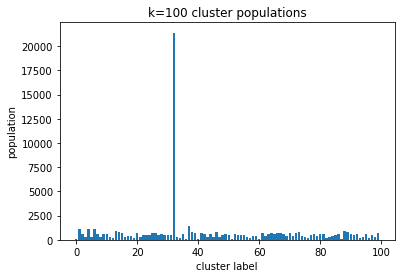

In [29]:
plt.bar(range(len(set(regular_km_model.labels_))), np.bincount(regular_km_model.labels_))

plt.ylabel('population')
plt.xlabel('cluster label')
plt.title('k={} cluster populations'.format(random_k));

#### Printing the most frequent words in our clusters

In [30]:
def strongest_features(model, vectorizer, topk=10):
    """
    Helper function to display a simple text representation of the top-k most
    important features in our fit model and vectorizer.

    model: sklearn model
    vectorizer: sklearn vectorizer
    topk: k numbers of words to get per cluster

    """
    # these parts are model-independent
    m_name = model.__class__.__name__
    features = vectorizer.get_feature_names()
    # different calculations per model type
    if m_name is 'KMeans':
        relevant_labels = list(set(model.labels_))
        centroids = model.cluster_centers_.argsort()[:,::-1]
        for this_label in relevant_labels:
            print('Cluster {}:'.format(this_label), end='')
            for ind in centroids[this_label, :topk]:
                print(' {}'.format(features[ind]), end='')
            print()
    else:
        raise NotImplementedError('This helper method currently only supports KMeans')

In [31]:
strongest_features(regular_km_model, vec, topk=15)

Cluster 0: buckingham lindsey fleetwood mac way tour go leav boot band guitarist fire left rumor finn
Cluster 1: run way still compani busi share tip improv say use form get end angel ranger
Cluster 2: woman polic man boyfriend charg embalm say aliv arrest die accus kill purs cocain stab
Cluster 3: seek polic fargo asylum well fine watchdog prosecutor record counti suspect abus rohingya buhari exclus
Cluster 4: state polic offic unit arrest say investig suspect chief shoot former secretari use search forc
Cluster 5: deficit trillion tax cut budget spend cbo analysi rais project feder send offic past bill
Cluster 6: trump presid memo democrat say white hous releas administr declassifi russia meet may probe june
Cluster 7: take step action quiz new level place find photo say nhl us golden moment whicker
Cluster 8: weekend menu item chain nation rain event warmth chanc past follow travel weather southern festiv
Cluster 9: today day get sunshin ago vote cloud year high read mix free headli

#### Obtaining tweet clusters

In [32]:
def cluster_sample(orig_text, model, idx, preview=15):
    """
    Helper function to display original bio for
    those users modeled in cluster `idx`.
    """
    print("Nombre de tweets dans le cluster " + str(idx) + ": "+ str(len(np.where(model.labels_ == idx)[0])))
    for i,idx in enumerate(np.where(model.labels_ == idx)[0]):
        print(orig_text[idx].replace('\n',' '))
        print()
        if i > preview:
            print('( >>> truncated preview <<< )')
            break

In [33]:
cluster_id = 36

cluster_sample(text, regular_km_model, cluster_id)

Nombre de tweets dans le cluster 36: 109
Sinclair host resigns after threat to sexually assault David Hogg with ‘hot poker’ https://t.co/ofZIengEHA https://t.co/vyA9fZ19JK

Conservative TV show host out at Sinclair station after David Hogg comment https://t.co/kdsnVj9Uy7 https://t.co/C7BJjrA32P

Conservative TV show host out at Sinclair station after David Hogg comment https://t.co/D1yvd09MTm https://t.co/w5noCHdFex

RT @BuzzFeedNews: A Sinclair TV host has resigned after he tweeted about violently assaulting David Hogg https://t.co/nBn3kaWFgX

A Sinclair TV host has resigned after he tweeted about violently assaulting David Hogg https://t.co/nBn3kaWFgX

A conservative commentator has resigned after tweeting about sexually assaulting Parkland shooting survivor David H… https://t.co/RrWfQhODbn

Commentator resigns after threatening to sexually assault gun control activist David Hogg https://t.co/zuXu90Ahve https://t.co/OlaMZG91WS

Commentator resigns after threatening to sexually assaul

In [34]:
cluster_id = 87

cluster_sample(text, regular_km_model, cluster_id)

Nombre de tweets dans le cluster 87: 105
Hari Kondabolu responds: “Congratulations to The Simpsons for being seen as relevant again” https://t.co/o85jFYlBUX

The Simpsons addressed Hari Kondabolu’s Problem With Apu with a ¯\_(ツ)_/¯: https://t.co/o85jFYlBUX https://t.co/eulRjsQqqp

Sunday's episode of “The Simpsons” took on complaints of stereotyping surrounding the character of Apu Nahasapeemap… https://t.co/BYkP6DpLKG

RT @CircaPop: 'Simpsons' reference to problem with Apu causes more problems https://t.co/DKbB6NRiRh https://t.co/NulymZAp01

Simpsons writers address Apu controversy and come under criticism https://t.co/W36KrUXrQA

Hari Kondabolu on Apu, the Simpsons character Hank Azaria doesn’t want to talk about: https://t.co/O2PhfMF2Fc https://t.co/OWO8uKwlfC

The Simpsons addressed Hari Kondabolu’s Problem With Apu with a ¯\_(ツ)_/¯: https://t.co/5mrNbT3CdO https://t.co/0szoKaxTqQ

The Simpsons addressed Hari Kondabolu’s Problem With Apu with a ¯\_(ツ)_/¯: https://t.co/8IhUZkzQDR ht

## K-Means Algorithm enhanced (continuation)

#### TF-IDF Matrix construction using bigram and trigrams this time

In [35]:
vectorizer = TfidfVectorizer(max_features=8000, ngram_range=(1, 3))
tf_idf_matrix_ngrams = vectorizer.fit_transform(tweets)

#### Finding the optimal amount of clusters (200)

In [ ]:
# compare a broad range of ks to start
ks = [2, 50, 200, 250, 350]

# track a couple of metrics
inertias = []

# fit the models, save the evaluation metrics from each run
for k in ks:
    print('fitting model for {} clusters'.format(k))
    model = KMeans(n_clusters=k, n_jobs=-1, random_state=seed, verbose=1)
    model.fit(tf_idf_matrix_ngrams)
    labels = model.labels
    inertias.append(model.inertia_)

fitting model for 2 clusters


In [ ]:
# plot the quality metrics for inspection
plt.style.use("bmh")
fig, ax = plt.subplots(1, 1, sharex=True)
plt.subplot(211)
plt.plot(ks, inertias, 'o--')
plt.ylabel('inertia')
plt.title('kmeans parameter search')

<img src="bestk.png">

#### Dimension reduction

In [38]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import TruncatedSVD

In [39]:
X_std = StandardScaler(with_mean=False).fit_transform(tf_idf_matrix_ngrams)

In [40]:
clf = TruncatedSVD(100,  random_state = 42)
svg = clf.fit_transform(tf_idf_matrix_ngrams)

#### Applying KMeans

In [41]:
best_k= 200
seed = 42
better_km_model = KMeans(n_clusters=best_k, n_jobs=-1, verbose=1, random_state=seed)
better_km_model.fit(svg)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=200, n_init=10, n_jobs=-1, precompute_distances='auto',
       random_state=42, tol=0.0001, verbose=1)

#### Visualizing our 200 clusters

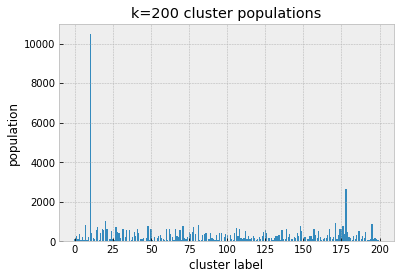

In [42]:
plt.bar(range(len(set(better_km_model.labels_))), np.bincount(better_km_model.labels_))

plt.ylabel('population')
plt.xlabel('cluster label')
plt.title('k={} cluster populations'.format(best_k));

#### Visualisation of tweets in a random cluster (7)
#### We can see that our clustering is efficient, all these treets have the common subject "war"/"crimes"

In [43]:
cluster_id = 7

cluster_sample(text, better_km_model, cluster_id)

Nombre de tweets dans le cluster 7: 814
Tajik president's third daughter gets position at Foreign Ministry https://t.co/3skG9zW9rY

Suppose Trump picks Romney over Giuliani for State. @SSestanovich suggests getting a few things in writing: https://t.co/vgzFEIpZLv 🔓

Smriti Irani pays Rs 100 to cobbler for getting slippers repaired | https://t.co/YXnHO9PNuu https://t.co/rXYzQbY33V

Ashley Graham gets her own curvy Barbie -- without the thigh gap: https://t.co/oPCdyTlLL7

The famous chef dishes about his tattoos and why he keeps getting them: https://t.co/Yg2krRU7yA

Out and about? Here's how to get score updates with the @BBCSport app https://t.co/tJ5nvFjCxK https://t.co/B5k0kYtLnF

RT @alibruceball: Swansea. Palace. Bradley. Pardew. Premier League. Pressure. Points. Prizes. Getting silly now. Updates on @5liveSport #bb…

You can get wicket alerts, direct to your phone, from the third #INDvENG Test in Mohali.  You just need the app! ➡️… https://t.co/2X6UjM821K

It's on  Tony Bellew v Da

#### Visualisation of tweets in a random cluster (9)
#### We can see that our clustering is efficient, all these treets have the common subject "school"

In [44]:
cluster_id = 9

cluster_sample(text, better_km_model, cluster_id)

Nombre de tweets dans le cluster 9: 202
Suicide Bombers Attack Pakistan Army Base Near Afghan Border https://t.co/Jige0PLtr9 https://t.co/GkYzKTmSxb

26/11 Mumbai attack: Never thought such attack would occur, says Jt CP Bharti | https://t.co/lMjtoj5mrE https://t.co/P90F43f927

CM Mamata Banerjee to step up attack on Modi government over demonetisation. https://t.co/zVRYaLl75e https://t.co/qp0ab4xUnP

Bandaru Dattatreya denounces Congress for attacking demonetisation | https://t.co/MR35ivXgrr https://t.co/aakUoVBzlD

RT @RashmiRajput123: #26/11- #storiesofstrength- CM- attack not on Mumbai, attack on the country. @IndianExpress

RT @Mumbai_Connect: Mumbai pays homage to victims of 26/11 terror attacks - https://t.co/dM9P1iQNji https://t.co/JE6CxCa30q

A secretive campaign of surveillance and drone attacks has cut ISIS's ability to inspire attacks in the West https://t.co/S5pEgVjbtW

JUST IN: Org. for the Prohibition of Chemical Weapons (OPCW) says a team "is preparing to deploy to Syri

## Improving our analysis using LDA

In [45]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.model_selection import GridSearchCV

In [46]:
tf_vectorizer = CountVectorizer(vocabulary=voc)
tf = tf_vectorizer.fit_transform(tweets)
tf_feature_names = tf_vectorizer.get_feature_names()

#### obtain LDA values

In [47]:
# Ce code est brise. https://github.com/scikit-learn/scikit-learn/issues/6777
search_params = {'n_components': [5, 20, 30, 40], 'learning_decay': [.5, .7, .9]}

lda = LatentDirichletAllocation()

model = GridSearchCV(lda, param_grid=search_params, n_jobs=-1)

model.fit(tf)

C:\Users\Elio\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


GridSearchCV(cv='warn', error_score='raise-deprecating',
             estimator=LatentDirichletAllocation(batch_size=128,
                                                 doc_topic_prior=None,
                                                 evaluate_every=-1,
                                                 learning_decay=0.7,
                                                 learning_method='batch',
                                                 learning_offset=10.0,
                                                 max_doc_update_iter=100,
                                                 max_iter=10,
                                                 mean_change_tol=0.001,
                                                 n_components=10, n_jobs=None,
                                                 perp_tol=0.1,
                                                 random_state=None,
                                                 topic_word_prior=None,
                                   

In [48]:
print(model.cv_results_['params'][model.best_index_])

{'learning_decay': 0.9, 'n_components': 5}


#### LDA method with learning_method='batch' 

In [49]:
no_topics = 200

lda_batch = LatentDirichletAllocation(n_components=no_topics, n_jobs=1,random_state=0).fit(tf)

#### LDA method with learning_method='online'

In [50]:
no_topics = 200
lda = LatentDirichletAllocation(n_components=no_topics, n_jobs=1, max_iter=5, learning_method='online', learning_offset=50.,random_state=0).fit(tf)

### Affichage et évalution des topics

In [51]:
def display_topics(model, feature_names, no_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print ("Topic: "+ str(topic_idx))
        print (" ".join([feature_names[i]
        for i in topic.argsort()[:-no_top_words - 1:-1]]))

#### Topics list

In [52]:
no_top_words = 50
display_topics(lda, tf_feature_names, no_top_words)

Topic: 0
make season tax local happen author feb user vehicl involv link deputi debut payment worri option electr construct excit nba bitcoin promot intellig wors convers select hike corpor regular gibson mayb hero hunter chair click andr shark exempt fifti whatev softwar contractor registr iron horribl bacon yard gestur motor corey
Topic: 1
may chief name militari staff approv trip justic cancel due hall replac financi flight financ facil appoint tension husband pakistan appli pilot signal bird theresa advisori zealand doj spokesman bayer monsanto ipl leas gig shade wolv thompson di po hungri priest antitrust lt sharif gen eri copper utter vw logo
Topic: 2
yo lopez reconnect jo latest region combin legion scope yield trace francisco chatham oppon foundat subject buffalo swastika hip eiffel colorado somali horribl straight fill toilet fitzpatrick troubl kitten blog chip panic kuwait lanka liverpool zero rather crore highway becam ut parcel speed petit valley toy larri chevrolet sat kni

#### Topics distribution in tweets

In [53]:
# Create Document - Topic Matrix
lda_output = lda.transform(tf)

# column names
topicnames = ["Topic" + str(i) for i in range(lda.n_components)]

# index names
docnames = [ i for i in range(len(text))]

# Make the pandas dataframe
df_document_topic = pd.DataFrame(np.round(lda_output, 2), columns=topicnames, index=docnames)

# Get dominant topic for each document
dominant_topic = np.argmax(df_document_topic.values, axis=1)
df_document_topic['dominant_topic'] = dominant_topic

# Styling
def color_green(val):
    color = 'green' if val > .1 else 'black'
    return 'color: {col}'.format(col=color)

def make_bold(val):
    weight = 700 if val > .1 else 400
    return 'font-weight: {weight}'.format(weight=weight)



#### Association of each tweet with the most probable topic

In [54]:
# Apply Style
df_document_topics = df_document_topic.head(50).style.applymap(color_green).applymap(make_bold)
df_document_topics

#### Printing the first 50 tweets 

In [55]:
for i, tweet in enumerate(text[:50]):
    print("Tweet " + str(i) + ":" + text[i])
print()

Tweet 0:Timeline of Fidel Castro's life https://t.co/HgN0iyQz0L https://t.co/c59GxrRaMx
Tweet 1:Polls open in Kuwait as opposition returns https://t.co/IBfZPJ9Ilt https://t.co/1rUoNmdPcq
Tweet 2:In Havana, music stops as Cubans mourn 'father' Castro https://t.co/rKzhGyabn6 https://t.co/USkbiCbAXL
Tweet 3:Foldable Cardboard Tube Brings Easy Eye Test to Developing World https://t.co/XqjGpyjoVk https://t.co/o1N0o4I90g
Tweet 4:Marianne Faithfull pays homage to Paris victims at Bataclan https://t.co/kchA0HcuiA https://t.co/00OpeneevO
Tweet 5:Pope to Everyman: Reaction to the Death of former Cuban President Fidel Castro https://t.co/EvSi0c9qKy https://t.co/BtuQ8PEsCM
Tweet 6:Iran arrests three over deadly train crash https://t.co/b8Q2n3NBEh https://t.co/ESnUgszf7T
Tweet 7:RT @W7VOA: #FidelCastro a "brutal dictator" with a legacy of oppression and firing squads, says @realDonaldTrump statement. https://t.co/t6…
Tweet 8:Thousands rally to demand S. Korea president's ouster https://t.co/WwhooP7

#### Visualisation of the word distribution in our topics

In [57]:
import pyLDAvis
import pyLDAvis.sklearn

#### Representation of the dispersion of topics and their most frequent words using LDA batch

In [58]:
pyLDAvis.enable_notebook()
panel = pyLDAvis.sklearn.prepare(lda_batch, tf, tf_vectorizer, mds='tsne')
panel

C:\Users\Elio\Anaconda3\lib\site-packages\pyLDAvis\_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


PreparedData(topic_coordinates=              x          y  topics  cluster      Freq
topic                                                
124   -4.457426  -9.477349       1        1  1.666694
188    7.619492  -0.038031       2        1  1.278491
173    4.350828  -3.456567       3        1  1.116950
79    -1.643257 -10.227993       4        1  1.065955
134   -2.417688  -8.414908       5        1  0.960743
...         ...        ...     ...      ...       ...
155    6.727103  -3.652017     196        1  0.309183
63    -0.472521   0.756861     197        1  0.303289
43     2.653763   0.825875     198        1  0.298622
133    0.037119   3.894578     199        1  0.292825
55     3.374881  -0.989518     200        1  0.279987

[200 rows x 5 columns], topic_info=      Category         Freq      Term        Total  loglift  logprob
7364   Default  3924.000000     trump  3924.000000  30.0000  30.0000
4908   Default  1660.000000     offic  1660.000000  29.0000  29.0000
3359   Default  1152.000000      hous  1152.000000  28.0000  28.0000
6857   Default  1157.000000   student  1157.000000  27.0000  27.0000
5364   Default  1348.000000     polic  1348.000000  26.0000  26.0000
...        ...          ...       ...          ...      ...      ...
7530  Topic200    20.307543       use   870.217750   2.1204  -4.2769
4762  Topic200    23.099076       new  3540.140786   0.8461  -4.1481
7623  Topic200    16.444664     video   797.755530   1.9964  -4.4878
7166  Topic200    12.891472  threaten   269.147455   2.8395  -4.7313
5364  Topic200    12.274824     polic  1348.692691   1.1788  -4.7803

[8733 rows x 6 columns], token_table=      Topic      Freq        Term
term                             
0       164  0.877213         aaa
0       185  0.087721         aaa
2        76  0.709215         aap
2        78  0.236405         aap
3       162  0.956057       aaron
...     ...       ...         ...
7994    142  0.779349         zoo
7994    155  0.194837         zoo
7996      3  0.899861        zuck
7997      3  0.998332  zuckerberg
7999     79  0.950573       zyban

[20055 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[125, 189, 174, 80, 135, 106, 47, 16, 180, 109, 116, 14, 33, 35, 4, 67, 120, 78, 65, 118, 192, 141, 87, 15, 17, 137, 24, 90, 107, 168, 50, 18, 143, 46, 178, 59, 83, 149, 51, 76, 170, 95, 153, 142, 29, 188, 111, 23, 54, 160, 103, 191, 91, 148, 28, 63, 92, 200, 96, 159, 114, 99, 81, 126, 85, 132, 179, 101, 171, 185, 177, 176, 183, 12, 166, 3, 199, 40, 165, 10, 196, 62, 68, 187, 75, 73, 117, 140, 152, 88, 66, 169, 72, 58, 37, 195, 104, 164, 9, 121, 186, 150, 79, 100, 25, 175, 32, 30, 157, 93, 136, 45, 122, 70, 139, 97, 129, 131, 113, 6, 48, 163, 154, 86, 42, 5, 1, 98, 26, 27, 7, 151, 115, 71, 182, 198, 123, 194, 69, 19, 34, 167, 119, 52, 41, 55, 39, 74, 102, 162, 22, 49, 158, 155, 190, 147, 11, 31, 105, 84, 145, 172, 21, 193, 124, 82, 61, 173, 197, 38, 60, 138, 112, 53, 57, 184, 144, 2, 110, 161, 89, 127, 146, 181, 108, 77, 43, 36, 94, 13, 133, 8, 20, 128, 130, 156, 64, 44, 134, 56])

#### Obtaining the most probable words of each topic

In [60]:
df_topic_keywords = pd.DataFrame(lda.components_)
topicnames = ["Topic" + str(i) for i in range(lda.n_components)]
# Assign Column and Index
df_topic_keywords.columns = tf_vectorizer.get_feature_names()
df_topic_keywords.index = topicnames

# View
df_topic_keywords.head()

aaa    aaf    aap  aaron     ab  abandon   abat   abba   abbi  \
Topic0  0.005  0.005  0.005  0.005  0.005    0.005  0.005  0.005  0.005   
Topic1  0.005  0.005  0.005  0.005  0.005    0.005  0.005  0.005  0.005   
Topic2  0.005  0.005  0.005  0.005  0.005    0.005  0.005  0.005  0.005   
Topic3  0.005  0.005  0.005  0.005  0.005    0.005  0.005  0.005  0.005   
Topic4  0.005  0.005  0.005  0.005  0.005    0.005  0.005  0.005  0.005   

        abbott  ...    zoe  zolciak  zombi   zone    zoo   zoom   zuck  \
Topic0   0.005  ...  0.005    0.005  0.005  0.005  0.005  0.005  0.005   
Topic1   0.005  ...  0.005    0.005  0.005  0.005  0.005  0.005  0.005   
Topic2   0.005  ...  0.005    0.005  0.005  0.005  0.005  0.005  0.005   
Topic3   0.005  ...  0.005    0.005  0.005  0.005  0.005  0.005  0.005   
Topic4   0.005  ...  0.005    0.005  0.005  0.005  0.005  0.005  0.005   

        zuckerberg   zuma  zyban  
Topic0       0.005  0.005  0.005  
Topic1       0.005  0.005  0.005  
Topic2       0.005  0.005  0.005  
Topic3       0.005  0.005  0.005  
Topic4       0.005  0.005  0.005  

[5 rows x 8000 columns]

### Time study

In [61]:
from datetime import datetime
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

#### Time distribution of all the tweets

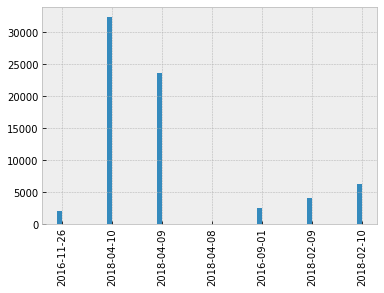

In [62]:
list_date = []
for date in created_at:
    list_date.append(datetime.strptime(date, '%a %b %d %H:%M:%S %z %Y').date())
    
labels, values = zip(*Counter(list_date).items())

indexes = np.arange(len(labels))
width = 0.1

plt.bar(indexes, values, width)
plt.xticks(indexes + width * 0.5, labels, rotation=90)
plt.show()

#### Time dstribution of tweets in the topic #16 

In [63]:
df_topics = pd.DataFrame(df_document_topic)
list_indexes_topic_16 = df_topics.index[df_topics['dominant_topic'] == 16].tolist()

In [64]:
list_date_topic_16 = []
for index in list_indexes_topic_16:
    list_date_topic_16.append(datetime.strptime(created_at[index], '%a %b %d %H:%M:%S %z %Y').date())

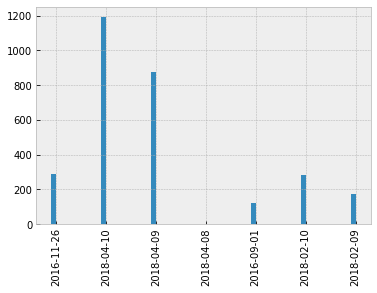

In [65]:
labels, values = zip(*Counter(list_date_topic_16).items())

indexes = np.arange(len(labels))
width = 0.1

plt.bar(indexes, values, width)
plt.xticks(indexes + width * 0.5, labels, rotation=90)
plt.show()